#### CNN's for NLP


* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* dataset: https://github.com/spro/practical-pytorch

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

### Import text-data from txt.files
__Dataset import__

In [2]:
# dataset location: ./dataset/names/*.txt
import glob

all_filenames = glob.glob('dataset/names/*.txt')
print(all_filenames)

['dataset/names/Arabic.txt', 'dataset/names/Chinese.txt', 'dataset/names/Czech.txt', 'dataset/names/Dutch.txt', 'dataset/names/English.txt', 'dataset/names/French.txt', 'dataset/names/German.txt', 'dataset/names/Greek.txt', 'dataset/names/Irish.txt', 'dataset/names/Italian.txt', 'dataset/names/Japanese.txt', 'dataset/names/Korean.txt', 'dataset/names/Polish.txt', 'dataset/names/Portuguese.txt', 'dataset/names/Russian.txt', 'dataset/names/Scottish.txt', 'dataset/names/Spanish.txt', 'dataset/names/Vietnamese.txt']


__Convert to non-ascii characters__

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + "_- .,;'0123456789"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [4]:
char2idx = {ch:i for i, ch in enumerate(all_letters)}
idx2char = {i:ch for i, ch in enumerate(all_letters)}
print(char2idx)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '_': 52, '-': 53, ' ': 54, '.': 55, ',': 56, ';': 57, "'": 58, '0': 59, '1': 60, '2': 61, '3': 62, '4': 63, '5': 64, '6': 65, '7': 66, '8': 67, '9': 68}


__Determine categories and words inside each txt file__

In [5]:

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# create a list of words for each category
for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    category_lines[category] = readLines(filename)

n_categories = len(all_categories)
print('n_categories =', n_categories)

# all_categories contains the keys to iterate over the category_lines dict
print(all_categories)

n_categories = 18
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


__Creating Tensors__
 
Usually add padding to the character-sequences to normalise length for the CNN input. Avoid this by treating each characters as a 1-hot vector of dimension n_letters.

In [6]:
num_batches = 1 

# every letter in a word should be represented by a vector
def word_to_tensor(word):
    list_of_chars = list(word)
    tensor = []
    tensor.append([char2idx[char] for char in word])
    return tensor

In [7]:
word_to_tensor('test_word')

[[19, 4, 18, 19, 52, 22, 14, 17, 3]]

In [8]:
# the X input is a list of all tensors, representing all names
all_x_input = []
for category in all_categories:
    for name in category_lines[category]:
        all_x_input.append(word_to_tensor(name)[0])

# the Y labels are the categories, where arabic is 0 and vietnamese is 17
all_y_input = []
for idx, category in enumerate(all_categories):
    for i in range(0, len(category_lines[category])):
        all_y_input.append(idx)


In [9]:
# the X input is a list of all tensors, representing all names
x_input = []
for category in all_categories:
    for idx in range(70): # 73 is the max for vietnamese
        x_input.append(word_to_tensor(category_lines[category][idx-1])[0])

# the Y labels are the categories, where arabic is 0 and vietnamese is 17
y_input = []
for idx, category in enumerate(all_categories):
    for i in range(70):
        y_input.append(idx)   

In [10]:
all_data = []
data = []
for idx, _ in enumerate(all_x_input):
    all_data.append([all_x_input[idx][:], all_y_input[idx]])

for idx, _ in enumerate(x_input):
    data.append([x_input[idx][:], y_input[idx]])
    
from random import shuffle
shuffle(all_data)
shuffle(data)


In [11]:
print(len(all_data), len(data))


20074 1260


In [12]:
# check which classes are represented in a slice
category_occurence = [0]*n_categories
for _, category in data:
    category_occurence[category] += 1
print(category_occurence)

[70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70]


In [13]:
import pandas as pd

dataframe = {
    'Category' : [i for i in all_categories],
    'num_examples': [category for category in category_occurence]
}

pd.DataFrame(dataframe)

,Category,num_examples
0,Arabic,70
1,Chinese,70
2,Czech,70
3,Dutch,70
4,English,70
5,French,70
6,German,70
7,Greek,70
8,Irish,70
9,Italian,70


#### CNN model
* 2 convolutional layers
* 2 pooling

In [14]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size, embedding_size):
        super(CNN, self).__init__()
        
        # Embedding
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=100, kernel_size=(2,n_letters), stride=1)
        self.activation1 = nn.ReLU()
        self.maxpool1 = nn.AdaptiveMaxPool2d((3,1), return_indices=False)
        
        '''# Convolution2
        self.cnn2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2,stride=1)
        self.activation2 = nn.ReLU()
        self.maxpool2 = nn.AdaptiveMaxPool2d(2)
        
        # Convolution3
        self.cnn3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,n_letters), stride=1)
        self.activation3 = nn.ReLU()
        self.maxpool3 = nn.AdaptiveMaxPool2d((2,1))
        
        # Convolution4
        self.cnn4 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,n_letters), stride=1)
        self.activation4 = nn.ReLU()
        self.maxpool4 = nn.AdaptiveMaxPool2d((2,1))
        
        # Convolution5
        self.cnn5 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,n_letters), stride=1)
        self.activation5 = nn.ReLU()
        self.maxpool5 = nn.AdaptiveMaxPool2d((2,1))
        
        # Convolution6
        self.cnn6 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,n_letters), stride=1)
        self.activation6 = nn.ReLU()
        self.maxpool6 = nn.AdaptiveMaxPool2d((2,1))
        
        # Convolution7
        self.cnn7 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,n_letters), stride=1)
        self.activation7 = nn.ReLU()
        self.maxpool7 = nn.AdaptiveMaxPool2d((2,1))'''

        # Fully connected 
        self.fc = nn.Linear(300, output_size) # n * channels, output_size
        
        
    def forward(self, x):
        if p:
            print(x.size())
        x = self.embedding(x)
        if p:
            print(x.size())
        x = x.unsqueeze(0)
        x = self.cnn1(x)
        x = self.activation1(x) + x
        x = self.maxpool1(x)
        if p:
            print(x.size())
            
        
        '''x = self.cnn2(x)
        x = self.activation2(x) + x
        x = self.maxpool2(x)
        
        x = self.cnn3(x)
        x = self.activation3(x)
        x = self.maxpool3(x)
        if p:
            print(x.size())
        x = self.cnn4(x)
        x = self.activation4(x)
        x = self.maxpool4(x)
        if p:
            print(x.size())
        x = self.cnn5(x)
        x = self.activation5(x)
        x = self.maxpool5(x)
        if p:
            print(x.size())
        x = self.cnn6(x)
        x = self.activation6(x)
        x = self.maxpool6(x)
        if p:
            print(x.size())
        x = self.cnn7(x)
        x = self.activation7(x)
        x = self.maxpool7(x)
        if p:
            print(x.size())'''
        
        # Resize
        # - original size: [wordlength - 1, batch_size, possible_bigrams: 69]
        # - x.size
        # - new output size: [wordlength - 1, batch_size, possible_bigrams: 69]
        #x = x.view(x.size(0),-1)
        x = x.view(1,-1)
        if p:
            print('view',x.size())
        x = self.fc(x)
        if p:
            print('linear:',x.size())
        
        return x

__Kernel size__
* $O = \frac{W-K+2P}{S}+1$
  * $O$: output heigth/length
  * $W$: input height/length
  * $K$: kernel size
  * $P$: padding
    * $ P = \frac{K-1}{2}$
  * $S$: Stride
* $O$ = len(word_to_bigrams)

In [15]:

# output_size = 18 classes
# input_size = 69 different tokens
# embedding_size = 69 different tokens?

model = CNN(n_letters, 18, n_letters)
if torch.cuda.is_available():
    model.cuda()

In [16]:
#define some parameters

epochs = 10
batch_size = 32
learning_rate = 0.01
momentum = 0.9


#define loss and optimizer

criterion = nn.CrossEntropyLoss() #cross entropy loss = log softmax + NLL loss
optimizer = optim.Adam(model.parameters())

In [17]:
#for plotting

plot_loss = []
plot_correct = []

In [18]:
# Considering a cuda model, otherwise remove .cpu() or write if/else 
'''
print(model.parameters())
print(len(list(model.parameters())))
print('Conv1 kernels:\n',list(model.parameters())[0].size())
print('Conv1 bias kernels:\n',list(model.parameters())[1].size())
print('Conv2 kernels (depth 16):\n',list(model.parameters())[2].size())
print('Conv2 bias kernels:\n',list(model.parameters())[3].size())
print('Fully connected layer:\n',list(model.parameters())[4].size())
print('Fully connected bias:\n',list(model.parameters())[5].size())'''


"\nprint(model.parameters())\nprint(len(list(model.parameters())))\nprint('Conv1 kernels:\n',list(model.parameters())[0].size())\nprint('Conv1 bias kernels:\n',list(model.parameters())[1].size())\nprint('Conv2 kernels (depth 16):\n',list(model.parameters())[2].size())\nprint('Conv2 bias kernels:\n',list(model.parameters())[3].size())\nprint('Fully connected layer:\n',list(model.parameters())[4].size())\nprint('Fully connected bias:\n',list(model.parameters())[5].size())"

In [19]:
def train(model, criterion, optimizer, x, y):
    
    # reset gradient
    optimizer.zero_grad()

    # forward pass
    fx = model.forward(x)
    
    # get the loss
    loss = criterion(fx, y)

    # backward pass
    loss.backward()

    # update parameters
    optimizer.step()

    # return the actual loss data, not the Variable
    return loss.data[0]

In [20]:
def predict(model, x, y):
    outputs = model(x)
    _, predicted = torch.max(outputs.data, 1) #for each output, get the predicted value (torch.max returns (index, value) tuple)
    correct = (predicted == y) #how many predicted values equal the labels
    return correct.sum()

In [21]:
iter = 0 
p = False            # print sizes of tensors
for e in range(1, epochs+1):
    loss = 0.
    correct = 0.
    model.train()
    for i, word in enumerate(data):
        if torch.cuda.is_available():
            x = Variable(torch.LongTensor([data[i][0]]), requires_grad=False).cuda() #converts list of indices to tensor of indices
            y = Variable(torch.LongTensor([data[i][1]]), requires_grad=False).cuda()
        else:
            x = Variable(torch.LongTensor([data[i][0]]), requires_grad=False)
            y = Variable(torch.LongTensor([data[i][1]]), requires_grad=False)
        loss += train(model, criterion, optimizer, x, y)
    
    model.eval()
    for i, word in enumerate(data):
        if torch.cuda.is_available():
            x = Variable(torch.LongTensor([data[i][0]]), requires_grad=False).cuda() #converts list of indices to tensor of indices
            y = torch.LongTensor([data[i][1]]).cuda()
        else:
            x = Variable(torch.LongTensor([data[i][0]]), requires_grad=False)
            y = torch.LongTensor([data[i][1]])    
        correct += predict(model, x, y)
    
    plot_loss.append(loss/len(data))
    plot_correct.append(correct/len(data)*100)
    print("Epoch %02d, loss = %f, accuracy = %.2f%%" % (e, loss / len(data), correct/len(data)*100))

Epoch 01, loss = 1.999831, accuracy = 66.27%
Epoch 02, loss = 1.256844, accuracy = 73.10%
Epoch 03, loss = 0.996569, accuracy = 77.22%
Epoch 04, loss = 0.843037, accuracy = 80.79%
Epoch 05, loss = 0.733092, accuracy = 81.51%
Epoch 06, loss = 0.688494, accuracy = 83.17%
Epoch 07, loss = 0.652622, accuracy = 83.89%
Epoch 08, loss = 0.640872, accuracy = 83.57%
Epoch 09, loss = 0.622755, accuracy = 85.79%
Epoch 10, loss = 0.588598, accuracy = 86.75%


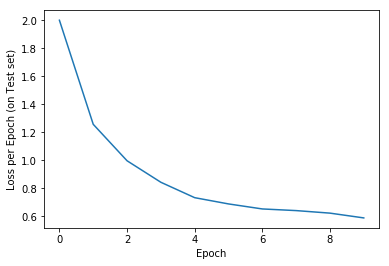

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss per Epoch (on Test set)')
plt.plot(plot_loss)

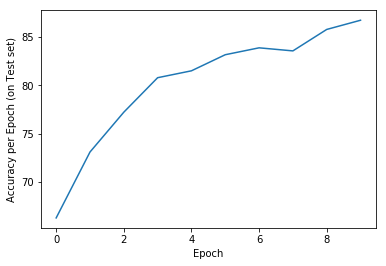

In [59]:
plt.plot(plot_correct)
plt.xlabel('Epoch')
plt.ylabel('Accuracy per Epoch (on Test set)')
plt.show()

In [60]:
p = False

In [75]:
import random
def random_training_pair():                                                                                                          
    choice = random.choice(data)
    line, category = choice

    if torch.cuda.is_available():
        category_tensor = torch.LongTensor(category).cuda()
        line_tensor = torch.LongTensor(line).cuda()
    else:
        category_tensor = torch.LongTensor(category)
        line_tensor = torch.LongTensor(line)
    return category, line, [category_tensor], line_tensor


def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

In [76]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    line_tensor = Variable(line_tensor).unsqueeze(0)
    output = model(line_tensor)
    guess, guess_i = category_from_output(output)


    confusion[category][guess_i] += 1


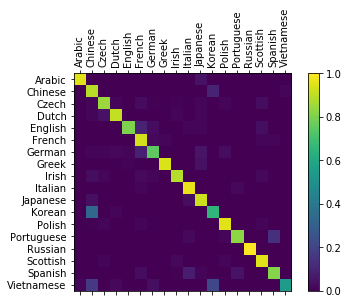

In [77]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [78]:
dataframe = {
    'Category' : [i for i in all_categories],
    'num_examples': [category for category in category_occurence]
}

pd.DataFrame(dataframe)

,Category,num_examples
0,Arabic,70
1,Chinese,70
2,Czech,70
3,Dutch,70
4,English,70
5,French,70
6,German,70
7,Greek,70
8,Irish,70
9,Italian,70


In [79]:
def predict_from_input(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    # Need to add some padding
    # while len(input_line) < max_len:
    #    input_line +='<PAD>'
    if torch.cuda.is_available():
        x = Variable(torch.LongTensor(word_to_tensor(input_line)), requires_grad=False).cuda()
    else:
        x = Variable(torch.LongTensor(word_to_tensor(input_line)), requires_grad=False)
    outputs = model(x)    
    
    # Get top N categories
    
    topv, topi = outputs.data.topk(n_predictions, 1, True)
    topv, topi = outputs.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])


In [80]:
predict_from_input('Smith')
predict_from_input('Test')
predict_from_input('Satoshi')

predict_from_input('Desmulliez')
predict_from_input('Konstas')
predict_from_input('Vincent')
predict_from_input('abcdefghijklmnopqrstuvwxyz67584374632ah87a7w4f03')


> Smith
(8.16) Scottish
(1.01) Irish
(0.09) Arabic

> Test
(20.97) Dutch
(15.85) German
(15.67) Scottish

> Satoshi
(18.49) Arabic
(5.08) Japanese
(2.78) Polish

> Desmulliez
(1.76) Portuguese
(1.72) Spanish
(0.44) Russian

> Konstas
(9.63) Portuguese
(9.31) Scottish
(8.26) Greek

> Vincent
(10.60) Dutch
(0.36) Czech
(0.31) Irish

> abcdefghijklmnopqrstuvwxyz67584374632ah87a7w4f03
(-16.32) Japanese
(-17.45) French
(-18.41) Russian
